In [1]:
from typing import List
import networkx as nx
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch_geometric.utils.convert import from_networkx

from collections import Counter
from sklearn.metrics import f1_score
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCN, global_mean_pool
from tqdm import tqdm
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

from pathlib import Path
import os
from random import shuffle
# custom modules
from models import Generator, Discriminator
from custom_dataset import CustomSequenceDataset
from preprecess_data import read_adfa_data, sequence_to_graph, fetch_graph_data
from utils import get_device, plot_loss_curve, evaluate_gcn_model
from classifiers import GCNModel
from train import train_gan_model
from train import train_gcn_model

# read, preprocess, and fetch the ADFA datasets

In [2]:
data_folder = "ADFA"  # make sure "ADFA" folder in the parent directory of this project's folder [ie., your codes]
current_directory = Path(os.getcwd())
parent_path = current_directory.parent.absolute()
# print(current_directory.parent.absolute())

full_data_folder_path = os.path.join(parent_path, data_folder)

In [3]:
adfa_sub_folders = ["Training_Data_Master","Validation_Data_Master", "Attack_Data_Master"]

benign_training_data_path = os.path.join(full_data_folder_path, adfa_sub_folders[0])
benign_validation_data_path = os.path.join(full_data_folder_path, adfa_sub_folders[1])

attack_data_path = os.path.join(full_data_folder_path, adfa_sub_folders[2])


# read the sub folders
benign_train_sequences, benign_train_labels  = read_adfa_data(benign_training_data_path)

benign_val_sequences, benign_val_labels  = read_adfa_data(benign_validation_data_path)

attack_sequences, attack_labels  = read_adfa_data(attack_data_path)

# the attack data are splitted into train and val data using 70% and 30% respectively.

shuffle(attack_sequences)  # shuffle the attack data so that the six attack categories are mixed up in the train and val data

# since, label is the 'same' = 1 for all the attack data, no need to shuffle it.
# split the attack_sequences
n_samples = int (len(attack_sequences) * 0.7)  
train_attack_sequences = attack_sequences[:n_samples]
train_attack_labels = attack_labels[:n_samples]

val_attack_sequences = attack_sequences[n_samples:]
val_attack_labels = attack_labels[n_samples:]


# Now, combine the both training data
train_data = benign_train_sequences + train_attack_sequences
train_labels = benign_train_labels + train_attack_labels

# combine the validation data
val_data = benign_val_sequences + val_attack_sequences
val_labels = benign_val_labels + val_attack_labels

len(train_data), len(train_labels), len(val_data), len(val_labels)

(2717, 2717, 9195, 9195)

In [4]:
len(attack_sequences)

1502

In [5]:
# Data is imbalanced: 1666 samples of benign & 1051 samples of attack (malignant) will be used for training the GCN model
Counter(train_labels) 

Counter({0: 1666, 1: 1051})

In [6]:
# Create a custom dataset 
batch_size = 64
# convert train_data sequences and val_data sequences into graphs

train_graph_dataset = fetch_graph_data(train_data, train_labels)
val_graph_dataset = fetch_graph_data(val_data, val_labels)


# Create a data loader
graph_train_loader = DataLoader(train_graph_dataset, batch_size=batch_size, shuffle=True)
graph_val_loader = DataLoader(val_graph_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# you can see the graph data: it has edge_index, weight, num_nodes, y (label of the graph, i.e., malign or benign), and x (node features). Here, x is a list of integers representing the node features. They need to be converted to a one-hot vector of size vocab_size or vector of embedded representation.
train_graph_dataset[0]

Data(edge_index=[2, 53], weight=[53], num_nodes=26, x=[1], y=0)

In [8]:
# device = get_device()
vocab_size = 342
hidden_dim = 128 # also the number of hidden nodes in the GCN. Can be set to 128, 256 or 512. If you have more GPU, you can increase it. However, you may face overfitting. Increase dropout if you face overfitting. Like dropout = 0.6, 0.7, 0.8
num_classes = 2
dropout = 0.6
output_dim = num_classes
# number of GCN layers, depending on your GPU, set it to any integer from 2 to 5.
num_layers = 3
EPOCHS_GCN = 35 


device=torch.device('cpu')


gcn_model = GCNModel(in_channels=vocab_size, hidden_channels=hidden_dim,out_channels=num_classes, num_layers=num_layers, dropout=dropout).to(device)

train_losses, train_f1_scores = train_gcn_model(gcn_model, graph_train_loader,  vocab_size=vocab_size,epochs=EPOCHS_GCN, device=device)

100%|██████████| 43/43 [00:00<00:00, 60.53it/s]


Epoch 1 / 35, Loss: 0.5860, F1 Score: 0.3073


100%|██████████| 43/43 [00:00<00:00, 57.70it/s]


Epoch 2 / 35, Loss: 0.4204, F1 Score: 0.8606


100%|██████████| 43/43 [00:00<00:00, 62.76it/s]


Epoch 3 / 35, Loss: 0.4017, F1 Score: 0.8774


100%|██████████| 43/43 [00:00<00:00, 62.85it/s]


Epoch 4 / 35, Loss: 0.3914, F1 Score: 0.8911


100%|██████████| 43/43 [00:00<00:00, 63.22it/s]


Epoch 5 / 35, Loss: 0.3865, F1 Score: 0.8973


100%|██████████| 43/43 [00:00<00:00, 64.24it/s]


Epoch 6 / 35, Loss: 0.3785, F1 Score: 0.9108


100%|██████████| 43/43 [00:00<00:00, 62.31it/s]


Epoch 7 / 35, Loss: 0.3790, F1 Score: 0.9138


100%|██████████| 43/43 [00:00<00:00, 59.14it/s]


Epoch 8 / 35, Loss: 0.3734, F1 Score: 0.9189


100%|██████████| 43/43 [00:00<00:00, 63.18it/s]


Epoch 9 / 35, Loss: 0.3684, F1 Score: 0.9250


100%|██████████| 43/43 [00:00<00:00, 59.51it/s]


Epoch 10 / 35, Loss: 0.3654, F1 Score: 0.9303


100%|██████████| 43/43 [00:00<00:00, 61.68it/s]


Epoch 11 / 35, Loss: 0.3582, F1 Score: 0.9392


100%|██████████| 43/43 [00:00<00:00, 58.85it/s]


Epoch 12 / 35, Loss: 0.3572, F1 Score: 0.9412


100%|██████████| 43/43 [00:00<00:00, 59.73it/s]


Epoch 13 / 35, Loss: 0.3576, F1 Score: 0.9407


100%|██████████| 43/43 [00:00<00:00, 50.60it/s]


Epoch 14 / 35, Loss: 0.3549, F1 Score: 0.9475


100%|██████████| 43/43 [00:00<00:00, 59.91it/s]


Epoch 15 / 35, Loss: 0.3557, F1 Score: 0.9430


100%|██████████| 43/43 [00:00<00:00, 59.29it/s]


Epoch 16 / 35, Loss: 0.3521, F1 Score: 0.9519


100%|██████████| 43/43 [00:00<00:00, 55.15it/s]


Epoch 17 / 35, Loss: 0.3473, F1 Score: 0.9576


100%|██████████| 43/43 [00:00<00:00, 61.88it/s]


Epoch 18 / 35, Loss: 0.3501, F1 Score: 0.9519


100%|██████████| 43/43 [00:00<00:00, 51.90it/s]


Epoch 19 / 35, Loss: 0.3465, F1 Score: 0.9602


100%|██████████| 43/43 [00:00<00:00, 59.77it/s]


Epoch 20 / 35, Loss: 0.3506, F1 Score: 0.9495


100%|██████████| 43/43 [00:00<00:00, 63.54it/s]


Epoch 21 / 35, Loss: 0.3456, F1 Score: 0.9579


100%|██████████| 43/43 [00:00<00:00, 62.58it/s]


Epoch 22 / 35, Loss: 0.3447, F1 Score: 0.9629


100%|██████████| 43/43 [00:00<00:00, 61.34it/s]


Epoch 23 / 35, Loss: 0.3445, F1 Score: 0.9604


100%|██████████| 43/43 [00:00<00:00, 62.59it/s]


Epoch 24 / 35, Loss: 0.3467, F1 Score: 0.9570


100%|██████████| 43/43 [00:00<00:00, 63.70it/s]


Epoch 25 / 35, Loss: 0.3438, F1 Score: 0.9601


100%|██████████| 43/43 [00:00<00:00, 63.58it/s]


Epoch 26 / 35, Loss: 0.3396, F1 Score: 0.9687


100%|██████████| 43/43 [00:00<00:00, 64.66it/s]


Epoch 27 / 35, Loss: 0.3442, F1 Score: 0.9610


100%|██████████| 43/43 [00:00<00:00, 63.81it/s]


Epoch 28 / 35, Loss: 0.3417, F1 Score: 0.9633


100%|██████████| 43/43 [00:00<00:00, 57.66it/s]


Epoch 29 / 35, Loss: 0.3404, F1 Score: 0.9626


100%|██████████| 43/43 [00:00<00:00, 65.94it/s]


Epoch 30 / 35, Loss: 0.3446, F1 Score: 0.9616


100%|██████████| 43/43 [00:00<00:00, 65.00it/s]


Epoch 31 / 35, Loss: 0.3400, F1 Score: 0.9687


100%|██████████| 43/43 [00:00<00:00, 64.96it/s]


Epoch 32 / 35, Loss: 0.3385, F1 Score: 0.9691


100%|██████████| 43/43 [00:00<00:00, 64.03it/s]


Epoch 33 / 35, Loss: 0.3400, F1 Score: 0.9651


100%|██████████| 43/43 [00:00<00:00, 62.24it/s]


Epoch 34 / 35, Loss: 0.3410, F1 Score: 0.9644


100%|██████████| 43/43 [00:00<00:00, 62.83it/s]

Epoch 35 / 35, Loss: 0.3365, F1 Score: 0.9746


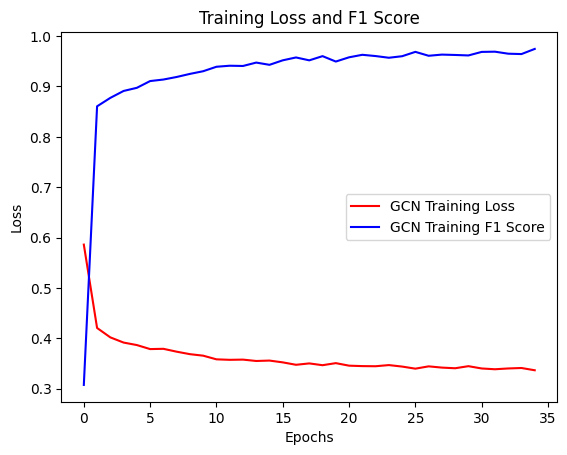

In [9]:
x = np.arange(EPOCHS_GCN, dtype=int)
plt.plot(x, train_losses, color="red", label="GCN Training Loss")
plt.plot(x, train_f1_scores, color="blue", label="GCN Training F1 Score")
plt.title("Training Loss and F1 Score")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
evaluate_gcn_model(gcn_model, graph_val_loader, vocab_size=vocab_size, device=device)

GCN performance:
Accuracy: 0.8883
Precision: 0.2949
Recall: 0.9180
F1 score: 0.4464
MCC: 0.4832


In [11]:
# PREPARE DATASET FOR GAN MODEL: pad the sequences to make them of same length, then trim them to a fixed sequence length to avoid too much padding.
from torch.nn.utils.rnn import pad_sequence
# convert train_data sequences and val_data sequences into graphs
SEQUENCE_LENGTH = 100
train_data_padded = pad_sequence([torch.tensor(sequence, dtype=torch.long) for sequence in train_data], batch_first=True)
val_data_padded = pad_sequence([torch.tensor(sequence, dtype=torch.long) for sequence in val_data], batch_first=True)

train_data_padded.shape, val_data_padded.shape

(torch.Size([2717, 2948]), torch.Size([9195, 4494]))

In [12]:
train_data_padded[:, SEQUENCE_LENGTH].shape, val_data_padded[:SEQUENCE_LENGTH].shape

# our dataset will be of shape (n_samples, SEQUENCE_LENGTH).
train_dataset = CustomSequenceDataset(train_data_padded[:, :SEQUENCE_LENGTH], train_labels) 
val_dataset = CustomSequenceDataset(val_data_padded[:, :SEQUENCE_LENGTH], val_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# hyperparameters of the generator and discriminator of the GAN model
latent_dim = 100
hidden_dim = 128
vocab_size = 342 # we have 342 unique system calls in the ADFA dataset
seq_len = SEQUENCE_LENGTH  # sequence length of the ADFA dataset with less than 120, will be padded. If sequence is longer than 120, it will be truncated.
output_dim = vocab_size
embed_dim = 10
dropout = 0.5
batch_size = 32
n_samples = 1000
num_classes = 2
lr = 1e-4 # 2e-6
epochs = 50
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss() 
device = get_device()
temperature = 0.2  # 0.1

gen = Generator(latent_dim, seq_len, hidden_dim, output_dim, embed_dim, dropout, conditional_info=True, num_classes=num_classes).to(
    device
)
# gen = Gen(latent_dim, hidden_dim, seq_len, output_dim, embed_dim, dropout).to(device)

disc = Discriminator(vocab_size,seq_len, hidden_dim, embed_dim, dropout, conditional_info=True, num_classes=num_classes).to(device)

gen_optimizer = Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

disc_optimizer = Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

In [14]:
# input_data = torch.randint(0, vocab_size, (n_samples, seq_len))
# input_labels = torch.randint(0, num_classes, (n_samples,))
# train_dataset = CustomSequenceDataset(input_data, input_labels)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [15]:
# note that the temperature is set to any value between 0 and 1. 
g_losses ,d_losses =  train_gan_model(
    gen,
    disc,
    gen_optimizer,
    disc_optimizer,
    train_loader,
    epochs,
    vocab_size,
    device=device,
    tau=temperature,
)

Epoch 1 / 50


100%|██████████| 43/43 [00:02<00:00, 15.38it/s]


D Loss: 1.3894, G Loss: -0.6542
Epoch 2 / 50


100%|██████████| 43/43 [00:02<00:00, 19.99it/s]


D Loss: 1.3902, G Loss: -0.6567
Epoch 3 / 50


100%|██████████| 43/43 [00:02<00:00, 19.61it/s]


D Loss: 1.3886, G Loss: -0.6710
Epoch 4 / 50


100%|██████████| 43/43 [00:02<00:00, 20.11it/s]


D Loss: 1.3888, G Loss: -0.6772
Epoch 5 / 50


100%|██████████| 43/43 [00:02<00:00, 18.25it/s]


D Loss: 1.3902, G Loss: -0.6769
Epoch 6 / 50


100%|██████████| 43/43 [00:02<00:00, 18.58it/s]


D Loss: 1.3888, G Loss: -0.6840
Epoch 7 / 50


100%|██████████| 43/43 [00:02<00:00, 19.35it/s]


D Loss: 1.3900, G Loss: -0.6884
Epoch 8 / 50


100%|██████████| 43/43 [00:02<00:00, 20.36it/s]


D Loss: 1.3823, G Loss: -0.6896
Epoch 9 / 50


100%|██████████| 43/43 [00:02<00:00, 20.10it/s]


D Loss: 1.3881, G Loss: -0.6901
Epoch 10 / 50


100%|██████████| 43/43 [00:02<00:00, 19.35it/s]


D Loss: 1.3838, G Loss: -0.6903
Epoch 11 / 50


100%|██████████| 43/43 [00:02<00:00, 20.21it/s]


D Loss: 1.3852, G Loss: -0.6894
Epoch 12 / 50


100%|██████████| 43/43 [00:02<00:00, 20.10it/s]


D Loss: 1.3876, G Loss: -0.6877
Epoch 13 / 50


100%|██████████| 43/43 [00:02<00:00, 19.69it/s]


D Loss: 1.3850, G Loss: -0.6945
Epoch 14 / 50


100%|██████████| 43/43 [00:02<00:00, 19.69it/s]


D Loss: 1.3909, G Loss: -0.6869
Epoch 15 / 50


100%|██████████| 43/43 [00:02<00:00, 19.72it/s]


D Loss: 1.3825, G Loss: -0.6917
Epoch 16 / 50


100%|██████████| 43/43 [00:02<00:00, 17.63it/s]


D Loss: 1.3846, G Loss: -0.6907
Epoch 17 / 50


100%|██████████| 43/43 [00:02<00:00, 19.28it/s]


D Loss: 1.3829, G Loss: -0.6938
Epoch 18 / 50


100%|██████████| 43/43 [00:02<00:00, 18.68it/s]


D Loss: 1.3892, G Loss: -0.6968
Epoch 19 / 50


100%|██████████| 43/43 [00:02<00:00, 18.85it/s]


D Loss: 1.3919, G Loss: -0.6912
Epoch 20 / 50


100%|██████████| 43/43 [00:02<00:00, 18.34it/s]


D Loss: 1.3889, G Loss: -0.6918
Epoch 21 / 50


100%|██████████| 43/43 [00:02<00:00, 19.33it/s]


D Loss: 1.3848, G Loss: -0.6896
Epoch 22 / 50


100%|██████████| 43/43 [00:02<00:00, 18.85it/s]


D Loss: 1.3867, G Loss: -0.6897
Epoch 23 / 50


100%|██████████| 43/43 [00:02<00:00, 19.45it/s]


D Loss: 1.3870, G Loss: -0.6925
Epoch 24 / 50


100%|██████████| 43/43 [00:02<00:00, 19.25it/s]


D Loss: 1.3901, G Loss: -0.6893
Epoch 25 / 50


100%|██████████| 43/43 [00:02<00:00, 18.43it/s]


D Loss: 1.3882, G Loss: -0.6934
Epoch 26 / 50


100%|██████████| 43/43 [00:02<00:00, 19.40it/s]


D Loss: 1.3903, G Loss: -0.6902
Epoch 27 / 50


100%|██████████| 43/43 [00:02<00:00, 17.41it/s]


D Loss: 1.3909, G Loss: -0.6936
Epoch 28 / 50


100%|██████████| 43/43 [00:02<00:00, 18.50it/s]


D Loss: 1.3905, G Loss: -0.6924
Epoch 29 / 50


100%|██████████| 43/43 [00:02<00:00, 18.39it/s]


D Loss: 1.3818, G Loss: -0.6966
Epoch 30 / 50


100%|██████████| 43/43 [00:02<00:00, 18.76it/s]


D Loss: 1.3851, G Loss: -0.6895
Epoch 31 / 50


100%|██████████| 43/43 [00:02<00:00, 18.37it/s]


D Loss: 1.3829, G Loss: -0.6891
Epoch 32 / 50


100%|██████████| 43/43 [00:02<00:00, 18.83it/s]


D Loss: 1.3908, G Loss: -0.6949
Epoch 33 / 50


100%|██████████| 43/43 [00:02<00:00, 16.93it/s]


D Loss: 1.3869, G Loss: -0.6919
Epoch 34 / 50


100%|██████████| 43/43 [00:02<00:00, 18.62it/s]


D Loss: 1.3825, G Loss: -0.6898
Epoch 35 / 50


100%|██████████| 43/43 [00:02<00:00, 18.35it/s]


D Loss: 1.3904, G Loss: -0.6917
Epoch 36 / 50


100%|██████████| 43/43 [00:02<00:00, 18.54it/s]


D Loss: 1.3871, G Loss: -0.6963
Epoch 37 / 50


100%|██████████| 43/43 [00:02<00:00, 18.45it/s]


D Loss: 1.3815, G Loss: -0.6907
Epoch 38 / 50


100%|██████████| 43/43 [00:02<00:00, 18.12it/s]


D Loss: 1.3865, G Loss: -0.6904
Epoch 39 / 50


100%|██████████| 43/43 [00:02<00:00, 17.81it/s]


D Loss: 1.3903, G Loss: -0.6909
Epoch 40 / 50


100%|██████████| 43/43 [00:02<00:00, 18.48it/s]


D Loss: 1.3853, G Loss: -0.6921
Epoch 41 / 50


100%|██████████| 43/43 [00:02<00:00, 18.02it/s]


D Loss: 1.3869, G Loss: -0.6922
Epoch 42 / 50


100%|██████████| 43/43 [00:02<00:00, 18.54it/s]


D Loss: 1.3869, G Loss: -0.6914
Epoch 43 / 50


100%|██████████| 43/43 [00:02<00:00, 18.50it/s]


D Loss: 1.3837, G Loss: -0.6922
Epoch 44 / 50


100%|██████████| 43/43 [00:02<00:00, 18.48it/s]


D Loss: 1.3874, G Loss: -0.6934
Epoch 45 / 50


100%|██████████| 43/43 [00:02<00:00, 18.49it/s]


D Loss: 1.3867, G Loss: -0.6901
Epoch 46 / 50


100%|██████████| 43/43 [00:02<00:00, 18.01it/s]


D Loss: 1.3768, G Loss: -0.6909
Epoch 47 / 50


100%|██████████| 43/43 [00:02<00:00, 18.49it/s]


D Loss: 1.3828, G Loss: -0.6990
Epoch 48 / 50


100%|██████████| 43/43 [00:02<00:00, 18.19it/s]


D Loss: 1.3834, G Loss: -0.6904
Epoch 49 / 50


100%|██████████| 43/43 [00:02<00:00, 16.32it/s]


D Loss: 1.3883, G Loss: -0.6916
Epoch 50 / 50


100%|██████████| 43/43 [00:02<00:00, 17.71it/s]

D Loss: 1.3821, G Loss: -0.6915


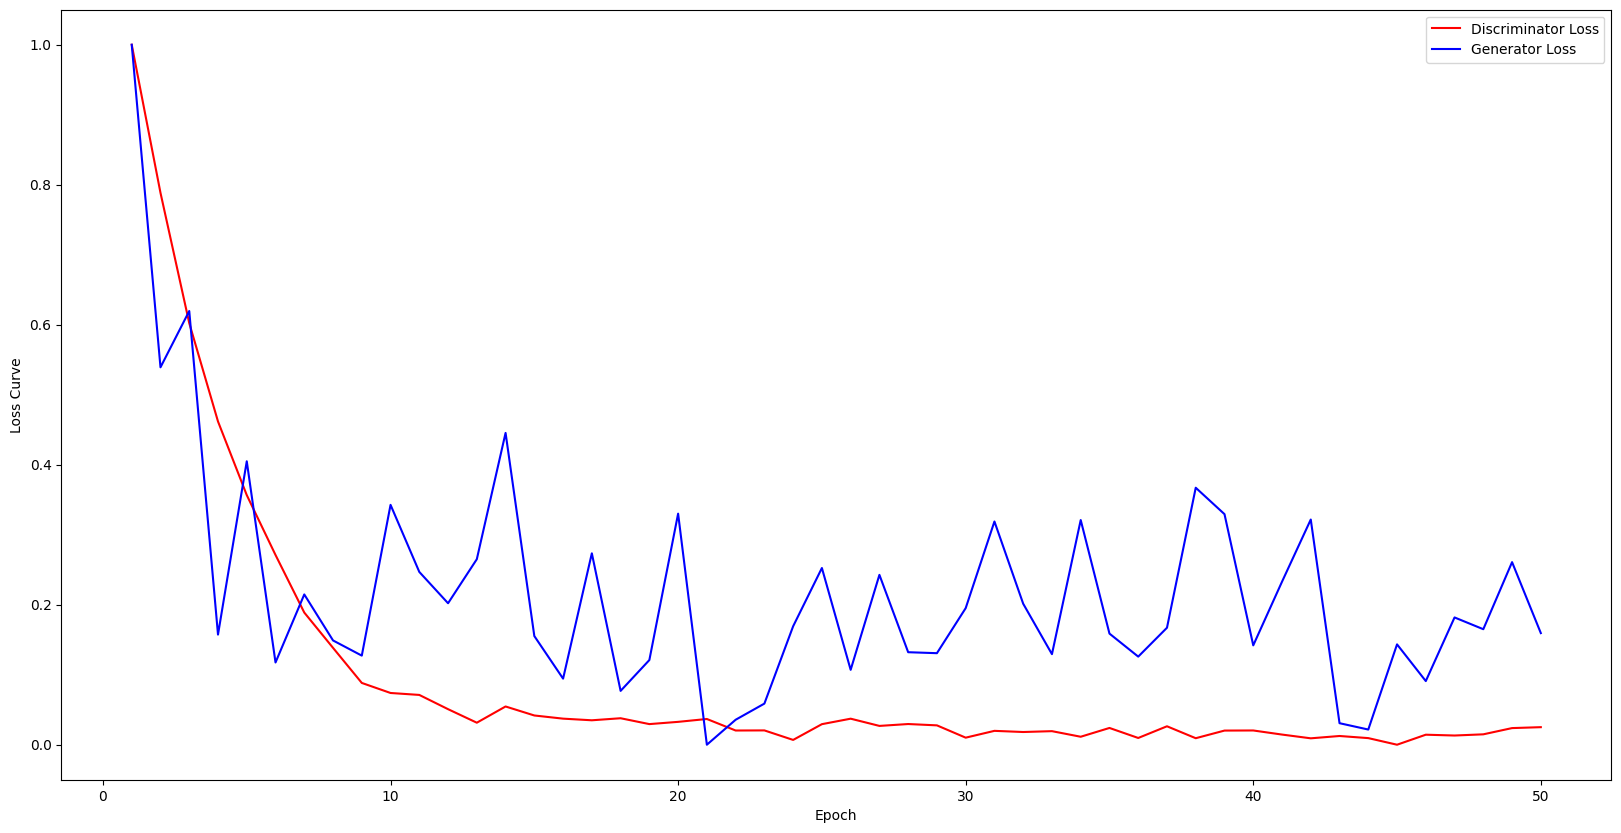

In [16]:
plot_loss_curve(g_losses, d_losses, epochs)

##  generate fake samples


In [32]:
fake_labels = torch.randint(0, num_classes, (n_samples,), dtype=torch.long)
z = torch.randn((n_samples, latent_dim))

# print("random noise shape", z.shape)
# set generator to eval mode
gen.eval()

fake_data = gen(z.to(device), fake_labels.to(device)).detach().cpu()

# print the generated data: if the data contains nan values, it means that there is gradient explosion, or other issues. To avoid such problems, change the termperature value to be between 0.1 and 0.5. Also, trying changing the learning rate to be between 5e-6 and 1e-4. Of course, this is just a suggestion. You might experiment with other values if you want, and report your findings.
# print(fake_data[0])

In [39]:
# get the generated samples as tokens (this are a sequence tokens or words / characters, represented by integers .)
from pprint import pprint

fake_samples = torch.argmax(fake_data, dim=-1).cpu().numpy()

# now, let's see two generated sequences
pprint(fake_samples[:2])

array([[137, 233, 169,  82, 228,   3, 185, 253, 248, 258,  76, 322, 178,
        237, 161, 229, 286,  70, 325, 153, 204, 162,  68,   1, 299, 176,
          0,  82, 188, 230, 307,  99, 126, 100,  20, 216, 124,  75, 284,
        325, 214,  73, 152, 272, 122, 318,   7, 280, 278,  40, 274, 216,
         62, 232, 247, 201, 238, 138, 106, 177,  13, 246,  59, 293, 111,
         37,  23, 224,  70, 182,  23, 277, 321, 335,  45, 146, 225, 311,
        308,  71,  29, 116,  75, 277, 115, 263, 168,  94, 192, 102, 114,
        209,  12,  70, 273, 150, 238, 194, 219, 307],
       [156, 208,   3, 118, 255,  59,  69, 144, 338, 159, 244, 153, 290,
         79,  12, 273, 265, 207, 299, 146, 184, 196, 228, 142,  93, 125,
        143, 322, 234,  86, 148,  33, 166,  80, 297, 188,  12, 288, 173,
         19, 317, 130, 210, 274,   7,  67, 280, 269, 223, 341, 299,  97,
         64, 146, 100, 174, 319, 230, 105, 204,  49, 246, 200, 284, 322,
        100,   9, 125, 108, 310,  22, 105, 317, 153, 241, 214, 222, 26

# Now, we can generate from generated tokens (i.e., sequence)
``` To do so, we can use the sequence_to_graph() function given in the preprocess_data.py```

In [29]:
# convert the generated samples into a networkx graph and also pytorch_geometric graph data object
networkx_graph, pytorch_geometric_data = sequence_to_graph(fake_samples[0])

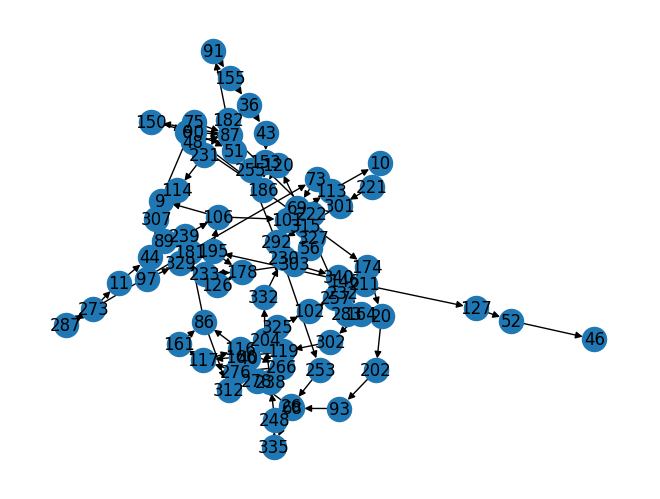

In [31]:
# you can see the networkx graph we generated
nx.draw(networkx_graph, with_labels=True)
plt.show()